lstm6

결과요약: RMSE: 0.15565380454063416  sales를 log를 취한 후 normalize한다.

[step: 499] loss: 1.981953740119934
RMSE: 0.15565380454063416

시도 내용 요약:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 

이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 제외함

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
tf.set_random_seed(7)


In [2]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac3.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [3]:
from datetime import datetime                    

# 1. 기본 feature

In [4]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

# 2. 추가 feature

In [5]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['season']=txs['date'].map(season)
txs['day_of_week']=txs['date'].map(day_of_week)
txs

,date,sales,year,month,week_number,season,day_of_week
0,2016-01-01,34,2016,1,53,0,4
1,2016-01-02,41,2016,1,53,0,5
2,2016-01-03,54,2016,1,53,0,6
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,0,1
5,2016-01-06,44,2016,1,01,0,2
6,2016-01-07,50,2016,1,01,0,3
7,2016-01-08,42,2016,1,01,0,4
8,2016-01-09,42,2016,1,01,0,5
9,2016-01-10,66,2016,1,01,0,6


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

# 3. 추가 가공

## 3.1 y의 추가 가공

In [7]:
xySales=txs['sales']
xySales=list(xySales)

### 이상점 제거

이상점 제거의 기준이 무척 주관적일 수 있으므로 제외하는 것이 좋을 수도 있어 lstm6는 이상점 제거를 하지 않았다.

normalization, bucketization 을 하여 새로운 열을 생성하는 방향으로

### log

In [8]:
xySales=np.log(xySales)
xySales

array([ 3.52636052,  3.71357207,  3.98898405,  3.71357207,  3.55534806,
        3.78418963,  3.91202301,  3.73766962,  3.73766962,  4.18965474,
        3.91202301,  4.00733319,  4.02535169,  3.97029191,  3.78418963,
        3.98898405,  3.98898405,  3.91202301,  3.68887945,  3.8918203 ,
        3.33220451,  4.27666612,  4.26267988,  3.97029191,  3.76120012,
        3.63758616,  4.00733319,  3.8918203 ,  3.76120012,  3.8918203 ,
        3.8918203 ,  3.78418963,  3.66356165,  3.95124372,  3.80666249,
        3.49650756,  3.76120012,  3.68887945,  3.8286414 ,  3.8918203 ,
        3.91202301,  3.61091791,  3.61091791,  3.80666249,  3.87120101,
        3.87120101,  3.63758616,  4.09434456,  3.4339872 ,  3.55534806,
        3.97029191,  4.24849524,  4.12713439,  3.87120101,  3.93182563,
        3.8918203 ,  3.63758616,  3.4657359 ,  3.66356165,  3.55534806,
        3.40119738,  3.58351894,  3.4339872 ,  3.4339872 ,  3.78418963,
        3.71357207,  3.71357207,  3.80666249,  3.8286414 ,  3.80

### Normalization

In [9]:
def MinMaxScaler(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

In [10]:
xySales=MinMaxScaler(xySales)

## 합쳐서 최종 input XY생성

In [11]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),xySales]

In [12]:
tempxy

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,


In [13]:
xy=np.array(tempxy)

In [14]:
xy

array([['0', '0', '0', ..., '0', '0', '0'],
       ['4', '5', '6', ..., '6', '0', '1'],
       ['53', '53', '53', ..., '04', '05', '05'],
       ['0.5557142370799633', '0.5852166429054146', '0.6286184327116974',
        ..., '0.0', '0.2536290760381732', '0.5411572543878042']], 
      dtype='<U32')

In [15]:
temp=xy.transpose()

In [16]:
temp

array([['0', '4', '53', '0.5557142370799633'],
       ['0', '5', '53', '0.5852166429054146'],
       ['0', '6', '53', '0.6286184327116974'],
       ..., 
       ['0', '6', '04', '0.0'],
       ['0', '0', '05', '0.2536290760381732'],
       ['0', '1', '05', '0.5411572543878042']], 
      dtype='<U32')

In [17]:
xy = temp.astype(np.float)

In [18]:
xy

array([[  0.        ,   4.        ,  53.        ,   0.55571424],
       [  0.        ,   5.        ,  53.        ,   0.58521664],
       [  0.        ,   6.        ,  53.        ,   0.62861843],
       ..., 
       [  0.        ,   6.        ,   4.        ,   0.        ],
       [  0.        ,   0.        ,   5.        ,   0.25362908],
       [  0.        ,   1.        ,   5.        ,   0.54115725]])

[[  0.           4.          53.           0.55571424]
 [  0.           5.          53.           0.58521664]
 [  0.           6.          53.           0.62861843]
 [  0.           0.           1.           0.58521664]
 [  0.           1.           1.           0.56028234]
 [  0.           2.           1.           0.59634517]
 [  0.           3.           1.           0.61649025]] -> [ 0.58901414]
[[  0.           5.          53.           0.58521664]
 [  0.           6.          53.           0.62861843]
 [  0.           0.           1.           0.58521664]
 [  0.           1.           1.           0.56028234]
 [  0.           2.           1.           0.59634517]
 [  0.           3.           1.           0.61649025]
 [  0.           4.           1.           0.58901414]] -> [ 0.58901414]
[[  0.           6.          53.           0.62861843]
 [  0.           0.           1.           0.58521664]
 [  0.           1.           1.           0.56028234]
 [  0.           2.          

 [  1.           6.          10.           0.61005717]] -> [ 0.58132537]
[[  1.           1.          10.           0.59988663]
 [  1.           2.          10.           0.60335026]
 [  1.           3.          10.           0.59988663]
 [  1.           4.          10.           0.58521664]
 [  1.           5.          10.           0.60673939]
 [  1.           6.          10.           0.61005717]
 [  1.           0.          11.           0.58132537]] -> [ 0.58901414]
[[  1.           2.          10.           0.60335026]
 [  1.           3.          10.           0.59988663]
 [  1.           4.          10.           0.58521664]
 [  1.           5.          10.           0.60673939]
 [  1.           6.          10.           0.61005717]
 [  1.           0.          11.           0.58132537]
 [  1.           1.          11.           0.58901414]] -> [ 0.57324213]
[[  1.           3.          10.           0.59988663]
 [  1.           4.          10.           0.58521664]
 [  1.     

 [  0.           5.          48.           0.37788097]] -> [ 0.41588536]
[[  3.           0.          48.           0.43692839]
 [  3.           1.          48.           0.37788097]
 [  3.           2.          48.           0.48711307]
 [  0.           3.          48.           0.42675785]
 [  0.           4.          48.           0.45548965]
 [  0.           5.          48.           0.37788097]
 [  0.           6.          48.           0.41588536]] -> [ 0.55571424]
[[  3.           1.          48.           0.37788097]
 [  3.           2.          48.           0.48711307]
 [  0.           3.          48.           0.42675785]
 [  0.           4.          48.           0.45548965]
 [  0.           5.          48.           0.37788097]
 [  0.           6.          48.           0.41588536]
 [  0.           0.          49.           0.55571424]] -> [ 0.36286117]
[[  3.           2.          48.           0.48711307]
 [  0.           3.          48.           0.42675785]
 [  0.     

[step: 33] loss: 3.409574031829834
[step: 34] loss: 3.384706974029541
[step: 35] loss: 3.3577566146850586
[step: 36] loss: 3.3298256397247314
[step: 37] loss: 3.301506280899048
[step: 38] loss: 3.2734010219573975
[step: 39] loss: 3.2462830543518066
[step: 40] loss: 3.220984935760498
[step: 41] loss: 3.198214292526245
[step: 42] loss: 3.1784164905548096
[step: 43] loss: 3.16170334815979
[step: 44] loss: 3.1478607654571533
[step: 45] loss: 3.1364054679870605
[step: 46] loss: 3.126678228378296
[step: 47] loss: 3.1179451942443848
[step: 48] loss: 3.109506845474243
[step: 49] loss: 3.100780963897705
[step: 50] loss: 3.0913655757904053
[step: 51] loss: 3.081071615219116
[step: 52] loss: 3.069918632507324
[step: 53] loss: 3.0581107139587402
[step: 54] loss: 3.0459847450256348
[step: 55] loss: 3.0339486598968506
[step: 56] loss: 3.0224149227142334
[step: 57] loss: 3.0117454528808594
[step: 58] loss: 3.0021984577178955
[step: 59] loss: 2.993908643722534
[step: 60] loss: 2.9868743419647217
[step

[step: 260] loss: 2.5899126529693604
[step: 261] loss: 2.5883240699768066
[step: 262] loss: 2.5867269039154053
[step: 263] loss: 2.5851218700408936
[step: 264] loss: 2.583505630493164
[step: 265] loss: 2.5818803310394287
[step: 266] loss: 2.580244541168213
[step: 267] loss: 2.5785977840423584
[step: 268] loss: 2.5769388675689697
[step: 269] loss: 2.5752670764923096
[step: 270] loss: 2.573582887649536
[step: 271] loss: 2.5718839168548584
[step: 272] loss: 2.5701701641082764
[step: 273] loss: 2.5684423446655273
[step: 274] loss: 2.566697597503662
[step: 275] loss: 2.564936399459839
[step: 276] loss: 2.5631580352783203
[step: 277] loss: 2.56136155128479
[step: 278] loss: 2.5595459938049316
[step: 279] loss: 2.5577120780944824
[step: 280] loss: 2.5558574199676514
[step: 281] loss: 2.5539820194244385
[step: 282] loss: 2.5520856380462646
[step: 283] loss: 2.5501673221588135
[step: 284] loss: 2.548226833343506
[step: 285] loss: 2.5462632179260254
[step: 286] loss: 2.544276237487793
[step: 287

[step: 488] loss: 2.0132358074188232
[step: 489] loss: 2.0104575157165527
[step: 490] loss: 2.007664442062378
[step: 491] loss: 2.004856824874878
[step: 492] loss: 2.002034902572632
[step: 493] loss: 1.9991997480392456
[step: 494] loss: 1.9963523149490356
[step: 495] loss: 1.9934924840927124
[step: 496] loss: 1.99062180519104
[step: 497] loss: 1.9877409934997559
[step: 498] loss: 1.9848517179489136
[step: 499] loss: 1.981953740119934
RMSE: 0.15565380454063416


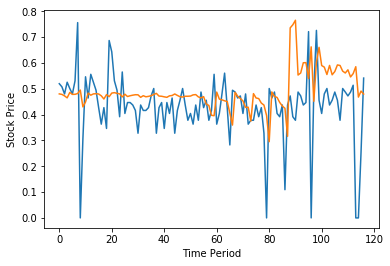

[step: 0] loss: 115.24762725830078
[step: 1] loss: 91.74622344970703
[step: 2] loss: 72.72180938720703
[step: 3] loss: 57.04624557495117
[step: 4] loss: 43.844295501708984
[step: 5] loss: 32.64288330078125
[step: 6] loss: 23.390336990356445
[step: 7] loss: 16.31804847717285
[step: 8] loss: 11.722257614135742
[step: 9] loss: 9.692018508911133
[step: 10] loss: 9.769668579101562
[step: 11] loss: 10.83837604522705
[step: 12] loss: 11.801884651184082
[step: 13] loss: 12.196099281311035
[step: 14] loss: 12.01093578338623
[step: 15] loss: 11.391064643859863
[step: 16] loss: 10.492472648620605
[step: 17] loss: 9.436442375183105
[step: 18] loss: 8.30582046508789
[step: 19] loss: 7.161818504333496
[step: 20] loss: 6.086647033691406
[step: 21] loss: 5.264671325683594
[step: 22] loss: 4.862273693084717
[step: 23] loss: 4.7860636711120605
[step: 24] loss: 4.354617595672607
[step: 25] loss: 3.986640214920044
[step: 26] loss: 3.739631414413452
[step: 27] loss: 3.5888662338256836
[step: 28] loss: 3.50

[step: 229] loss: 2.6370182037353516
[step: 230] loss: 2.6355419158935547
[step: 231] loss: 2.6340625286102295
[step: 232] loss: 2.6325795650482178
[step: 233] loss: 2.631094217300415
[step: 234] loss: 2.629605531692505
[step: 235] loss: 2.628115177154541
[step: 236] loss: 2.6266205310821533
[step: 237] loss: 2.625124216079712
[step: 238] loss: 2.6236255168914795
[step: 239] loss: 2.6221249103546143
[step: 240] loss: 2.6206214427948
[step: 241] loss: 2.6191160678863525
[step: 242] loss: 2.617607593536377
[step: 243] loss: 2.616097927093506
[step: 244] loss: 2.6145851612091064
[step: 245] loss: 2.6130709648132324
[step: 246] loss: 2.6115529537200928
[step: 247] loss: 2.6100332736968994
[step: 248] loss: 2.6085102558135986
[step: 249] loss: 2.6069843769073486
[step: 250] loss: 2.605454921722412
[step: 251] loss: 2.6039223670959473
[step: 252] loss: 2.602386236190796
[step: 253] loss: 2.6008455753326416
[step: 254] loss: 2.5993008613586426
[step: 255] loss: 2.597750663757324
[step: 256] l

[step: 459] loss: 2.0868945121765137
[step: 460] loss: 2.0845744609832764
[step: 461] loss: 2.082242965698242
[step: 462] loss: 2.0798985958099365
[step: 463] loss: 2.0775396823883057
[step: 464] loss: 2.0751655101776123
[step: 465] loss: 2.0727756023406982
[step: 466] loss: 2.0703694820404053
[step: 467] loss: 2.067946195602417
[step: 468] loss: 2.065505266189575
[step: 469] loss: 2.063047409057617
[step: 470] loss: 2.060572385787964
[step: 471] loss: 2.058079481124878
[step: 472] loss: 2.055569887161255
[step: 473] loss: 2.0530428886413574
[step: 474] loss: 2.05049991607666
[step: 475] loss: 2.0479400157928467
[step: 476] loss: 2.0453643798828125
[step: 477] loss: 2.0427727699279785
[step: 478] loss: 2.0401651859283447
[step: 479] loss: 2.0375425815582275
[step: 480] loss: 2.0349040031433105
[step: 481] loss: 2.032250165939331
[step: 482] loss: 2.0295801162719727
[step: 483] loss: 2.026895046234131
[step: 484] loss: 2.0241944789886475
[step: 485] loss: 2.0214784145355225
[step: 486] 

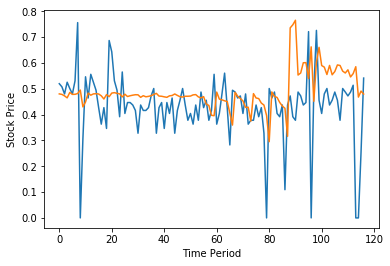

In [19]:
#train parameters
seq_length=7
data_dim=4
hidden_dim=10
output_dim=1
learning_rate=0.01
iterations=500
#기본형식
#기본 인자로는 ds-y로 받고 
#처리함수에서 ds를 받아서 'feature 처리모듈'에서 ds에서 요일(주중, 주말), 월(계절) + 날씨와 같은 추가 요인-값을 받는다.


x=xy
y=xy[:,[-1]]

#build a dataset
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

#input place holders
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, 1])
# build a LSTM network(input: cell shape, type/ )
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# use the last cell's output to calculate Y_pred
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=tf.tanh) 
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
